In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import os
import glob
import os

In [2]:
img_size = 200
img_dir = r"C:\Users\Ritul\Documents\Python Scripts\IML_Final_project\input\images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() 

In [3]:
# array to store resized images
imgs=[]

# resizing all images
print('Resizing images....')
for f in tqdm(files):
    img = cv2.imread(f)
    img = cv2.resize(img, (img_size,img_size))
    imgs.append(np.array(img))
print('Resizing Complete!')
print(np.array(imgs).shape)

  1%|          | 4/433 [00:00<00:13, 31.33it/s]

Resizing images....


100%|██████████| 433/433 [00:12<00:00, 34.50it/s]

Resizing Complete!
(433, 200, 200, 3)


In [4]:
#Function for Extracting resized bounding box annotations from xml files
from lxml import etree
def bboxannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        x_low = int(dim.xpath("xmin")[0].text)/(width/img_size)
        y_low = int(dim.xpath("ymin")[0].text)/(height/img_size)
        x_high = int(dim.xpath("xmax")[0].text)/(width/img_size)
        y_high = int(dim.xpath("ymax")[0].text)/(height/img_size)
    return [int(x_high), int(y_high), int(x_low), int(y_low)]

In [5]:
path = 'input/annotations'
path_f = path + '/'
img_annotations = [path_f + i for i in sorted(os.listdir(path))]
#array to store bounding box annotations
bbox = []

print('Extracting bounding box annotations....')
for i in img_annotations:
    bbox.append(bboxannotation(i))
print('bounding box annotations extracted!')

Extracting bounding box annotations....
bounding box annotations extracted!


[167, 129, 90, 93]


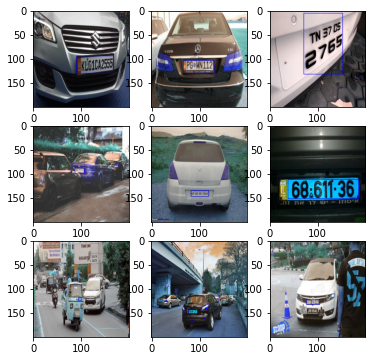

In [6]:
#visualizing a bounding box 
print(bbox[0])
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i in range(9):
    plt.subplot(3,3,i+1)    # the number of images in the grid is 5*5 (25)
    image = cv2.rectangle(imgs[i],(bbox[i][0],bbox[i][1]),(bbox[i][2],bbox[i][3]),(0, 0, 255))
    plt.imshow(image)
    

plt.show()
# for i in range(5):
#     image = cv2.rectangle(imgs[i],(bbox[i][0],bbox[i][1]),(bbox[i][2],bbox[i][3]),(0, 0, 255))
#     plt.imshow(image)
#     plt.show()

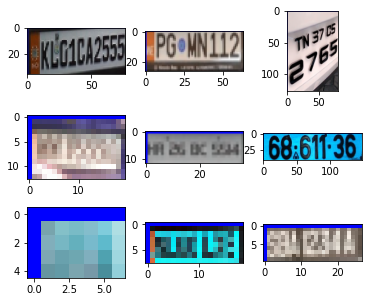

In [7]:
# cropping the number plate to display
plt.figure(figsize=(6, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    number_plate = imgs[i][bbox[i][3]:bbox[i][1], bbox[i][2]:bbox[i][0]]
    plt.imshow(number_plate)
plt.show()

In [8]:
# Localizing plates using pre-trained Haar-cascade
plate_cascade = cv2.CascadeClassifier('indian_licensePlate_HaarCascade.xml')
hrc_bbox = []
def detect_plate(img, text=''): # the function detects the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate
    for (x,y,w,h) in plate_rect:
        plate = roi[y:y+h, x:x+w, :] #cropping out plate region
        hrc_bbox.append([y,y+h,x,x+w])
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (255,0,0), 2) # bounding box the detected plate
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
    
    return plate_img, plate 

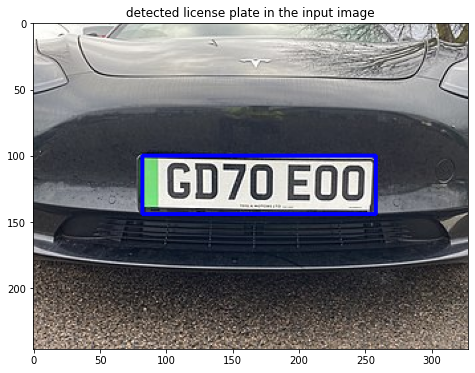

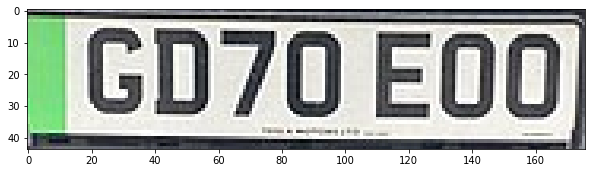

In [9]:
# General function to show images
def show(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.imshow(img)
    plt.title(title)
    plt.show()

output_img, plate = detect_plate(cv2.imread('car3.jpg'))
show(output_img, 'detected license plate in the input image')
show(plate)

In [10]:

def find_contours(dimensions, img) :
    
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [11]:
def char_segmentation(image) :
    
    # Preprocess cropped license plate image
    lp_img = cv2.resize(image, (333, 75))

    #grayscale image
    lp_gray = cv2.cvtColor(lp_img, cv2.COLOR_BGR2GRAY)

    # Gaussian filtering
    blur = cv2.GaussianBlur(lp_gray,(5,5),0)

    # OTSU thresholding/binarization
    lp_smth, lp_binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # pixel is 1 only if all pixel around it is 1
    lp_binary = cv2.erode(lp_binary, (3,3))
    # pixel is 1 iff atleast one pixel is 1
    lp_binary = cv2.dilate(lp_binary, (3,3))

    LP_WIDTH = lp_binary.shape[0]
    LP_HEIGHT = lp_binary.shape[1]

    # Whitening image borders
    lp_binary[0:4,:] = lp_binary[:,0:4] = lp_binary[71:75,:] = lp_binary[:,329:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    plt.imshow(lp_binary, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',lp_binary)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, lp_binary)

    return char_list

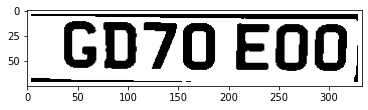

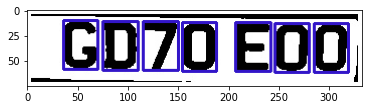

In [12]:
char = char_segmentation(plate)
#prints processed lp and then segmented chars

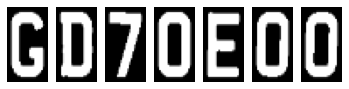

In [13]:
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
# cv2.imwrite('char2.jpg',char[1])

In [14]:
# #pytesseract # works with contour images!!
# #lets benchmark classification results with tesseract result
# import pytesseract
# from PIL import Image

# # pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Ritul\AppData\Local\Programs\Python\Python39\Scripts\pytesseract.exe'
# pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
# text= pytesseract.image_to_string(Image.open('contour.jpg'))
# text

'GD70 E00,\n'

## Model Building

In [15]:
# importing model building libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

In [16]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255)

path = 'input/char_data/data'
train_generator = data_gen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  
        batch_size=1,
        class_mode='sparse',shuffle=False)

test_generator = data_gen.flow_from_directory(
        path+'/val', 
        target_size=(28,28),  
        class_mode='sparse',shuffle=False)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [17]:
def get_model_plots(hist):
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

##### Shallow MLP (2 hidden layers(10 units each))

Epoch 1/10
864/864 [==============================] - 8s 8ms/step - loss: 3.2173 - accuracy: 0.0961 - val_loss: 2.6487 - val_accuracy: 0.2454
Epoch 2/10
864/864 [==============================] - 4s 5ms/step - loss: 2.3149 - accuracy: 0.2396 - val_loss: 1.9078 - val_accuracy: 0.3565
Epoch 3/10
864/864 [==============================] - 4s 5ms/step - loss: 1.5413 - accuracy: 0.4549 - val_loss: 1.2577 - val_accuracy: 0.5972
Epoch 4/10
864/864 [==============================] - 5s 5ms/step - loss: 0.9994 - accuracy: 0.6470 - val_loss: 0.9480 - val_accuracy: 0.6620
Epoch 5/10
864/864 [==============================] - 4s 5ms/step - loss: 0.6931 - accuracy: 0.7396 - val_loss: 0.6326 - val_accuracy: 0.8148
Epoch 6/10
864/864 [==============================] - 4s 5ms/step - loss: 0.5335 - accuracy: 0.8183 - val_loss: 0.4656 - val_accuracy: 0.8611
Epoch 7/10
864/864 [==============================] - 4s 4ms/step - loss: 0.4117 - accuracy: 0.8565 - val_loss: 0.3694 - val_accuracy: 0.8750
Epoch 

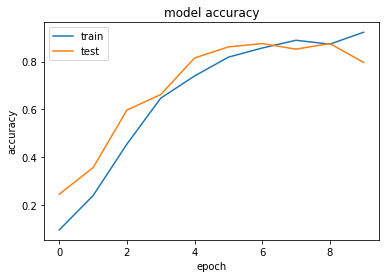

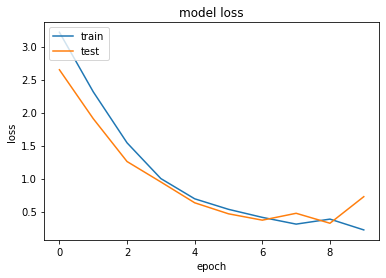

In [18]:
S_mlp = keras.Sequential(
    [
    layers.Flatten(),
    layers.Dense(28, activation='relu', name='layer1'),
    layers.Dense(10, activation='relu', name='layer2'),
    layers.Dense(10, activation='relu', name='layer4'),
    layers.Dense(36, activation='softmax', name='layer5')
    ]
)

# Compile model
S_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train/fit model
hist_S_mlp = 0
hist_S_mlp = S_mlp.fit(train_generator,
      steps_per_epoch = train_generator.samples // 1,
      validation_data = test_generator, 
      epochs = 10)
e = S_mlp.evaluate(test_generator)
print(S_mlp.metrics_names)
print('SHALLOW MLP ACCURACY: ',e[1] )
get_model_plots(hist_S_mlp)

S_mlp.save('models/S_mlp_model.h5')

In [105]:
# from tensorflow.keras.preprocessing import image
# from keras import models
class_arr = ['0','1','2','3','4','5','6','7','8','9','A','B',\
    'C','D','E','F', 'G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','X','Y','Z']
    
# client_img_path = "char2.jpg"
# c_img = image.load_img(client_img_path, target_size=(28, 28))
# img_array = image.img_to_array(c_img)
# img_batch = np.expand_dims(img_array,axis=0)
# pred = S_mlp.predict(img_batch)

# result = class_arr[pred.argmax()]
# result

# def img_pred_class(path,model):
#     c_img = image.load_img(path, target_size=(28, 28))
#     img_array = image.img_to_array(c_img)
#     img_batch = np.expand_dims(img_array,axis=0)
#     pred = S_mlp.predict(img_batch)

#     result = class_arr[pred.argmax()]
#     print(result)

# img_pred_class("char2.jpg")

##### Deep MLP (12 Hidden layers (10 units each))

Epoch 1/10
864/864 [==============================] - 3s 3ms/step - loss: 3.5884 - accuracy: 0.0197 - val_loss: 3.5838 - val_accuracy: 0.0278
Epoch 2/10
864/864 [==============================] - 2s 2ms/step - loss: 3.5866 - accuracy: 0.0185 - val_loss: 3.5837 - val_accuracy: 0.0278
Epoch 3/10
864/864 [==============================] - 2s 2ms/step - loss: 3.5865 - accuracy: 0.0162 - val_loss: 3.5837 - val_accuracy: 0.0278
Epoch 4/10
864/864 [==============================] - 2s 2ms/step - loss: 3.5865 - accuracy: 0.0197 - val_loss: 3.5836 - val_accuracy: 0.0278
Epoch 5/10
864/864 [==============================] - 2s 2ms/step - loss: 3.5864 - accuracy: 0.0139 - val_loss: 3.5836 - val_accuracy: 0.0278
Epoch 6/10
864/864 [==============================] - 2s 2ms/step - loss: 3.5864 - accuracy: 0.0139 - val_loss: 3.5836 - val_accuracy: 0.0278
Epoch 7/10
864/864 [==============================] - 2s 2ms/step - loss: 3.5864 - accuracy: 0.0139 - val_loss: 3.5836 - val_accuracy: 0.0278
Epoch 

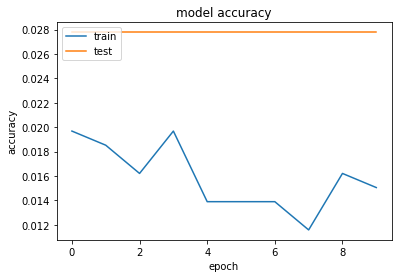

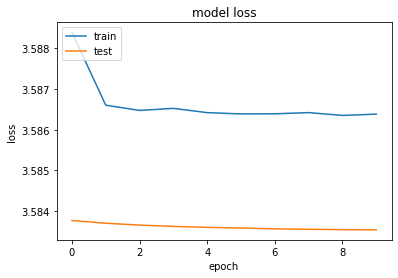

In [53]:
x = 10
D_mlp = keras.Sequential(
    [
    layers.Flatten(),
    layers.Dense(28, activation='relu', name='layer1'),
    layers.Dense(x, activation='relu', name='layer2'),
    layers.Dense(x, activation='relu', name='layer3'),
    layers.Dense(x, activation='relu', name='layer4'),
    layers.Dense(x, activation='relu', name='layer5'),
    layers.Dense(x, activation='relu', name='layer6'),
    layers.Dense(x, activation='relu', name='layer7'),
    layers.Dense(x, activation='relu', name='layer8'),
    layers.Dense(x, activation='relu', name='layer9'),
    layers.Dense(x, activation='relu', name='layer10'),
    layers.Dense(x, activation='relu', name='layer11'),
    layers.Dense(x, activation='relu', name='layer12'),
    layers.Dense(x, activation='relu', name='layer13'),
    layers.Dense(36, activation='sigmoid', name='layer14'),
    ]
)

# Compile model
D_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train/fit model
hist_D_mlp = 0
hist_D_mlp = D_mlp.fit(train_generator,
      steps_per_epoch = train_generator.samples // 1,
      validation_data = test_generator, 
      epochs = 10)

e = D_mlp.evaluate(test_generator)
print('DEEP MLP ACCURACY: ',e[1] )

get_model_plots(hist_D_mlp)

#### Layer comparison

In [45]:
# fit model with given number of layers, returns test set accuracy
def evaluate_model(n_layers, train_generator, test_generator):
	
	
	# define model
	model = keras.Sequential()
	model.add(layers.Dense(28, activation='relu'))
	for _ in range(1, n_layers):
		model.add(layers.Dense(10, activation='relu'))
	model.add(layers.Flatten())
	model.add(layers.Dense(36, activation='softmax'))

	# compile model
	model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	history = model.fit(train_generator,
      steps_per_epoch = train_generator.samples // 1,
      validation_data = test_generator, 
      epochs = 10)
	# evaluate model on test set
	# print(history.history.keys())
	
	test_acc = model.evaluate(test_generator)

	# print(model.metrics_names)
	return history, test_acc[1]

---------------For 1 hidden layers------------------
Epoch 1/10
864/864 [==============================] - 12s 13ms/step - loss: 0.7617 - accuracy: 0.8113 - val_loss: 0.1770 - val_accuracy: 0.9537
Epoch 2/10
864/864 [==============================] - 11s 13ms/step - loss: 0.0841 - accuracy: 0.9769 - val_loss: 0.0818 - val_accuracy: 0.9630
Epoch 3/10
864/864 [==============================] - 11s 13ms/step - loss: 0.0787 - accuracy: 0.9780 - val_loss: 0.0997 - val_accuracy: 0.9537
Epoch 4/10
864/864 [==============================] - 11s 13ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0229 - val_accuracy: 0.9907
Epoch 5/10
864/864 [==============================] - 12s 13ms/step - loss: 0.0350 - accuracy: 0.9919 - val_loss: 0.0397 - val_accuracy: 0.9907
Epoch 6/10
864/864 [==============================] - 12s 14ms/step - loss: 0.0467 - accuracy: 0.9861 - val_loss: 0.0244 - val_accuracy: 0.9907
Epoch 7/10
864/864 [==============================] - 12s 14ms/step - loss: 0.0913 

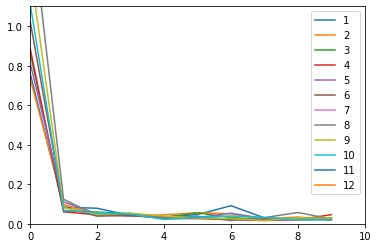

In [38]:
# Loss over epochs for differetn layers
num_layers = [i for i in range(1,13)]
for n_layers in num_layers:
	print(f"---------------For {n_layers} hidden layers------------------")
	# evaluate model with a given number of layers
	history, result = evaluate_model(n_layers, train_generator, test_generator)
	print('layers=%d: %.3f' % (n_layers, result))
	# plot learning curve
	plt.plot(history.history['loss'], label=str(n_layers))
	# print(history.history)
	# print(history.history['loss'])
	print('---------------------------------------------------------------')
plt.xlim(0,10)
plt.ylim(0,1.1)
plt.legend()
plt.show()

---------------For 1 hidden layers------------------
Epoch 1/10
864/864 [==============================] - 10s 11ms/step - loss: 0.8150 - accuracy: 0.8229 - val_loss: 0.1946 - val_accuracy: 0.9306
Epoch 2/10
864/864 [==============================] - 10s 12ms/step - loss: 0.1344 - accuracy: 0.9699 - val_loss: 0.0713 - val_accuracy: 0.9954
Epoch 3/10
864/864 [==============================] - 10s 11ms/step - loss: 0.0651 - accuracy: 0.9780 - val_loss: 0.0598 - val_accuracy: 0.9769
Epoch 4/10
864/864 [==============================] - 11s 13ms/step - loss: 0.0642 - accuracy: 0.9838 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 5/10
864/864 [==============================] - 11s 13ms/step - loss: 0.0620 - accuracy: 0.9838 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 6/10
864/864 [==============================] - 11s 12ms/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.0219 - val_accuracy: 1.0000
Epoch 7/10
864/864 [==============================] - 11s 13ms/step - loss: 0.0349 

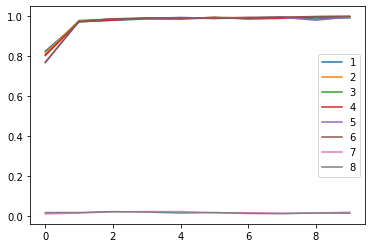

In [47]:
# Accuracy over epochs for different layers (1-8)
num_layers = [i for i in range(1,9)]
for n in num_layers:
	print(f"---------------For {n} hidden layers------------------")
	# evaluate model with a given number of layers
	history, result = evaluate_model(n, train_generator, test_generator)
	print('layers=%d: %.3f' % (n, result))
	# plot learning curve
	plt.plot(history.history['accuracy'], label=str(n))
	# print(history.history)
	# print(history.history['loss'])
	print('---------------------------------------------------------------')
# plt.xlim(0,10)
# plt.ylim(0,1.1)
plt.legend()
plt.show()

---------------For 1 hidden layers------------------
Epoch 1/10
864/864 [==============================] - 11s 12ms/step - loss: 0.7716 - accuracy: 0.8148 - val_loss: 0.3426 - val_accuracy: 0.9028
Epoch 2/10
864/864 [==============================] - 9s 10ms/step - loss: 0.1036 - accuracy: 0.9745 - val_loss: 0.0831 - val_accuracy: 0.9537
Epoch 3/10
864/864 [==============================] - 9s 10ms/step - loss: 0.0486 - accuracy: 0.9838 - val_loss: 0.2802 - val_accuracy: 0.9537
Epoch 4/10
864/864 [==============================] - 8s 9ms/step - loss: 0.0927 - accuracy: 0.9803 - val_loss: 0.0609 - val_accuracy: 0.9676
Epoch 5/10
864/864 [==============================] - 10s 12ms/step - loss: 0.0731 - accuracy: 0.9826 - val_loss: 0.3090 - val_accuracy: 0.9537
Epoch 6/10
864/864 [==============================] - 9s 11ms/step - loss: 0.0797 - accuracy: 0.9792 - val_loss: 0.0108 - val_accuracy: 0.9954
Epoch 7/10
864/864 [==============================] - 10s 12ms/step - loss: 0.0306 - acc

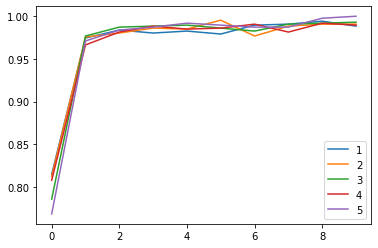

In [48]:
# Accuracy over epochs for different layers (1-8)
num_layers = [i for i in range(1,6)]
for n in num_layers:
	print(f"---------------For {n} hidden layers------------------")
	# evaluate model with a given number of layers
	history, result = evaluate_model(n, train_generator, test_generator)
	print('layers=%d: %.3f' % (n, result))
	# plot learning curve
	plt.plot(history.history['accuracy'], label=str(n))
	# print(history.history)
	# print(history.history['loss'])
	print('---------------------------------------------------------------')
# plt.xlim(0,10)
# plt.ylim(0,1.1)
plt.legend()
plt.show()

#### CNN

Epoch 1/10
864/864 [==============================] - 5s 5ms/step - loss: 3.3532 - accuracy: 0.0613 - val_loss: 2.8647 - val_accuracy: 0.1667
Epoch 2/10
864/864 [==============================] - 4s 4ms/step - loss: 2.2603 - accuracy: 0.2465 - val_loss: 1.6952 - val_accuracy: 0.3843
Epoch 3/10
864/864 [==============================] - 5s 6ms/step - loss: 1.4228 - accuracy: 0.4734 - val_loss: 1.0574 - val_accuracy: 0.6296
Epoch 4/10
864/864 [==============================] - 7s 8ms/step - loss: 1.0235 - accuracy: 0.6100 - val_loss: 0.8064 - val_accuracy: 0.7361
Epoch 5/10
864/864 [==============================] - 5s 5ms/step - loss: 0.7537 - accuracy: 0.7060 - val_loss: 0.7630 - val_accuracy: 0.7315
Epoch 6/10
864/864 [==============================] - 5s 5ms/step - loss: 0.5900 - accuracy: 0.7859 - val_loss: 0.5052 - val_accuracy: 0.8426
Epoch 7/10
864/864 [==============================] - 6s 7ms/step - loss: 0.5104 - accuracy: 0.8044 - val_loss: 0.6064 - val_accuracy: 0.7778
Epoch 

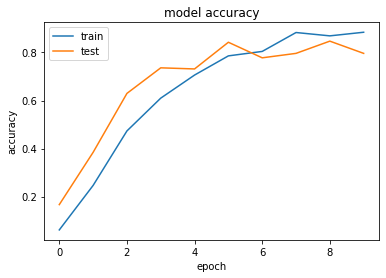

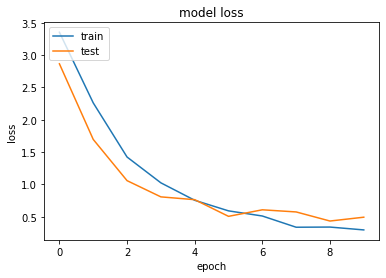

In [203]:
from tensorflow.keras import layers
cnn = keras.Sequential(
    [
        layers.Conv2D(12,kernel_size = (3, 3),activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(36, activation='softmax')
    ]
)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile model
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train/fit model
hist_cnn = 0
hist_cnn = cnn.fit(train_generator,
      steps_per_epoch = train_generator.samples // 1,
      validation_data = test_generator, 
      epochs = 10)

e = cnn.evaluate(test_generator)
print('CNN ACCURACY: ',e[1] )

get_model_plots(hist_cnn)

In [63]:
# cnn.summary()
S_mlp.summary()
# D_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 layer1 (Dense)              (None, 28)                65884     
                                                                 
 layer2 (Dense)              (None, 10)                290       
                                                                 
 layer4 (Dense)              (None, 10)                110       
                                                                 
 layer5 (Dense)              (None, 36)                396       
                                                                 
Total params: 66,680
Trainable params: 66,680
Non-trainable params: 0
_________________________________________________________________


In [ ]:
####### FLOW ########

#detect_plate => input img with boundung box of lp, cropped_lp

#char_segmentation => prints processed lp and then segmented chars in an array char[i]

#Each i in char array must be passed to a clf model to get individual predictions

#combine the predictions to get model derived lp number

#Get pytesseract output from processed lp

#compare both results

In [27]:
# from keras import models
# # S_mlp.predict('char2.jpg')
# loaded_model = models.load_model("models/S_mlp_model.h5")

# client_img_path = "char2.jpg"
# c_img = image.load_img(client_img_path, target_size=(100, 100))
# img_array = image.img_to_array(c_img)
# img_batch = np.expand_dims(img_array, axis=0)
# result = loaded_model.predict(img_batch)

In [129]:
# from PIL import Image as im
# # h = plt.imshow(char[0])
# # type(char[0])

# # cv2.imwrite('smth.jpg',char[0]) 
# client_img_path = "char2.jpg"
# c_img = image.load_img(client_img_path, target_size=(28, 28))
# img_array = image.img_to_array(c_img)
# img_batch = np.expand_dims(img_array, axis=0)
# pred = cnn.predict(img_batch)
# # S_mlp.predict('smth.jpg')
# result = class_arr[pred.argmax()]
# pred

array([[0.0277626 , 0.02784644, 0.02780687, 0.02757946, 0.02789037,
        0.02777608, 0.02791835, 0.02765291, 0.0277632 , 0.02786631,
        0.02782566, 0.02771186, 0.02786577, 0.02787682, 0.02794438,
        0.02772366, 0.0274206 , 0.02786339, 0.0278457 , 0.02789241,
        0.02787231, 0.0278834 , 0.02789765, 0.02756268, 0.02800129,
        0.02779105, 0.02781504, 0.02751991, 0.0277125 , 0.02781383,
        0.02751122, 0.02773709, 0.0278706 , 0.0279095 , 0.02776554,
        0.02750352]], dtype=float32)

In [60]:
# print(' No. of paramters in Shallow MLP = ', S_mlp.count_params())
# print(' No. of paramters in Deep MLP = ', D_mlp.count_params())
# print(' No. of paramters in CNN = ', cnn.count_params())


 No. of paramters in Shallow MLP =  66680
 No. of paramters in Deep MLP =  67780
 No. of paramters in CNN =  57800


In [122]:
#pytesseract # works with contour images!!
#lets benchmark classification results with tesseract result
import pytesseract
from PIL import Image

# pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Ritul\AppData\Local\Programs\Python\Python39\Scripts\pytesseract.exe'

def ocr_pred(path):
    pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
    text= pytesseract.image_to_string(Image.open(path))
    for i in text:
        if i not in class_arr:
            text = text.replace(i,"")
    return text
ocr_pred('car5.jpeg')

'CCPHHO1AV8866'

In [115]:
from tensorflow.keras.preprocessing import image
from keras import models
class_arr = ['0','1','2','3','4','5','6','7','8','9','A','B',\
    'C','D','E','F', 'G','H','I','J','K','L','M','N','O','P','Q',\
    'R','S','T','U','V','W','X','Y','Z']
print(len(class_arr))
def img_pred_class(path,model):
    c_img = image.load_img(path, target_size=(28, 28))
    try: 
        os.remove(path)
    except: pass
    img_array = image.img_to_array(c_img)
    img_batch = np.expand_dims(img_array,axis=0)
    pred = model.predict(img_batch)
    # print(pred.argmax())

    result = class_arr[pred.argmax()]
    return result



36


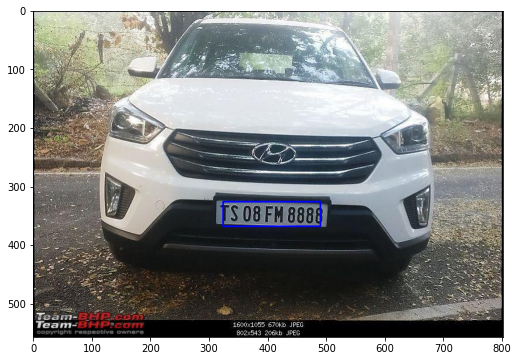

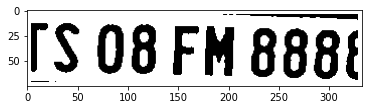

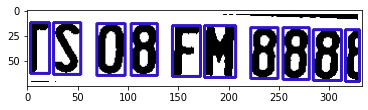

Recognized License Plate is:  B3Q35J3J34
OCR recognized License Plate is:  SO08FM888


In [235]:
####### Main function ########
import os
from scipy.spatial import distance 

def anpr(img, model):
    m = model
#detect_plate => input img with boundung box of lp, cropped_lp
    bb_lp, lp = detect_plate(cv2.imread(img))
    show(bb_lp)
#char_segmentation => prints processed lp and then segmented chars in an array char[i]
    char = char_segmentation(lp)
#Each i in char array must be passed to a clf model to get individual predictions
    pred_lp = []
    # print(len(char))
    for i in range(len(char)):

        cv2.imwrite(f'{i}.jpg',char[i])
        c = f"{i}.jpg"

        result = img_pred_class(c,model)
        pred_lp.append(result)
        res_lp = ''.join(pred_lp)
        # print(result)
        ocr_lp = ocr_pred('contour.jpg') #Get pytesseract output from processed lp
    print('Recognized License Plate is: ',res_lp)
    print('OCR recognized License Plate is: ',ocr_lp )
    try:
        score = distance.hamming(list(res_lp),list(ocr_lp))
        succ = round((1-score)*100,2)
        print('Success rate: ', f'{succ}%')
    except: pass

    
anpr('car8_seg.jpg',cnn)


#car14 closeup with lighting works well
#car3 closeup without lighting is fine
#car8 show char seg better in this model over ocr
#car4 shows cascade error